In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import random 
import os 
import pandas as pd 

from work import handler
from work import casestudy
from work import storm_tracker
from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 3.72 seconds


In [2]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)

## whole data
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_99"] = np.max(ft.LC_instant_prec_99th, axis=1)
ft["INT_max_accumulated_95"] = np.max(ft.LC_accumulated_prec_95th, axis=1)
ft["INT_max_instant_95"] = np.max(ft.LC_instant_prec_95th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_total_prec, axis=1)
ft_aligned = ft.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation


In [3]:
# from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.ml_tools.standard_scaler_from_ds import scale_profiles_v1

X, X_scaled, scaler_profiles = scale_profiles_v1(ds)

from tensorflow import keras
latent_space_size = 32
model_name = 'ae_fully_connected_v1'+f"_latent_{latent_space_size}"
ae_name = f'{model_name}_v0.keras'
save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)

# Load the autoencoder
autoencoder = keras.models.load_model(save_path_ae)
# Print the model summary to identify layers
autoencoder.summary()

# Using the name of the bottleneck layer
encoder_output = autoencoder.get_layer('dense_18').output  # Replace 'bottleneck' with actual name

# Or, if you know the index of the bottleneck layer
# encoder_output = autoencoder.layers[n].output  # Replace n with the actual index

# Reconstruct the encoder model
encoder = keras.Model(inputs=autoencoder.input, outputs=encoder_output)
print("Autoencoder input shape:", autoencoder.input_shape)
print("X_scaled shape:", X_scaled.shape)

# Encode the data
X_latent = encoder.predict(X_scaled)
print("Latent representation shape:", X_latent.shape)

# load UMAP embeddings and cluster labels as numpy arrays
X_umap_name = "X_umap_v0.npy"
X_umap_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, X_umap_name) 
X_umap = np.load(X_umap_savepath)

clusters_name = "hdbscan_labels_v0_of_X_umap_v0.npy"
clusters_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, clusters_name)
X_umap_clusters_label = np.load(clusters_savepath)

2024-12-02 14:48:25.330751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 14:48:25.531668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 14:48:25.590355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 14:48:25.954819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 14:48:28.294661: W tensorflow/compiler/tf2

Model: "ae_fully_connected_v1_latent_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 52, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 728)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       186,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 728)            │       187,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 52, 14)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,381,226 (5.27 MB)

 Trainable params: 460,408 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 920,818 (3.51 MB)

Autoencoder input shape: (None, 52, 14)
X_scaled shape: (528, 52, 14)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Latent representation shape: (528, 32)


In [4]:
print("Original :       ",  X.shape)
print("Latent :         ", X_latent.shape)
print("Viz du latent :  ", X_umap.shape)
print("Labels :         ", X_umap_clusters_label.shape)

DCS_number = ds.coords['DCS_number'].values  # Assuming 'DCS_number' is your sample identifier
latent_dim = X_latent.shape[1]


# Create DataArray for the latent representation
da_X_latent = xr.DataArray(
    X_latent,
    dims=['DCS_number', 'latent_dim'],
    coords={'DCS_number': DCS_number, 'latent_dim': np.arange(latent_dim)},
    name='latent_representation'
)

# Create DataArray for the UMAP visualization
da_X_umap = xr.DataArray(
    X_umap,
    dims=['DCS_number', 'umap_dim'],
    coords={'DCS_number': DCS_number, 'umap_dim': ['umap1', 'umap2']},
    name='umap_projection'
)

# Create DataArray for the cluster labels
da_X_umap_clusters_label = xr.DataArray(
    X_umap_clusters_label,
    dims=['DCS_number'],
    coords={'DCS_number': DCS_number},
    name='cluster_labels'
)

ds_new = xr.Dataset({
    'latent_representation': da_X_latent,
    'umap_projection': da_X_umap,
    'cluster_labels': da_X_umap_clusters_label
})

ds_all = xr.merge([ds, ft_aligned, ds_new])
ds_all

Original :        (528, 52, 14)
Latent :          (528, 32)
Viz du latent :   (528, 2)
Labels :          (528,)


<xarray.Dataset>
Dimensions:                   (DCS_number: 528, z: 52, time: 911,
                               latent_dim: 32, umap_dim: 2)
Coordinates:
  * DCS_number                (DCS_number) int64 153512 153524 ... 295399 297410
  * z                         (z) float32 20.0 61.2 ... 1.447e+04 1.497e+04
  * time                      (time) int64 817681 817682 ... 818590 818591
  * latent_dim                (latent_dim) int64 0 1 2 3 4 5 ... 27 28 29 30 31
  * umap_dim                  (umap_dim) <U5 'umap1' 'umap2'
Data variables: (12/42)
    TABS_init_profile         (DCS_number, z) float64 305.0 304.7 ... 206.8
    QV_init_profile           (DCS_number, z) float64 15.84 15.83 ... 0.002887
    U_init_profile            (DCS_number, z) float64 -0.01247 ... 6.671
    V_init_profile            (DCS_number, z) float64 -0.002984 ... 0.594
    TABS_max_instant_profile  (DCS_number, z) float64 305.0 304.6 ... 206.2
    QV_max_instant_profile    (DCS_number, z) float64 16.06 16.05 ... 0.003031
    ...                        ...
    INT_max_accumulated_95    (DCS_number) float64 45.5 48.25 ... 10.94 62.84
    INT_max_instant_95        (DCS_number) float64 23.27 22.8 ... 6.008 18.73
    INT_sum_total             (DCS_number) float64 4.983e+04 ... 2.805e+04
    latent_representation     (DCS_number, latent_dim) float32 3.224 ... 12.3
    umap_projection           (DCS_number, umap_dim) float32 5.049 ... 9.943
    cluster_labels            (DCS_number) int64 2 8 8 6 4 -1 4 ... 1 7 -1 5 8 3

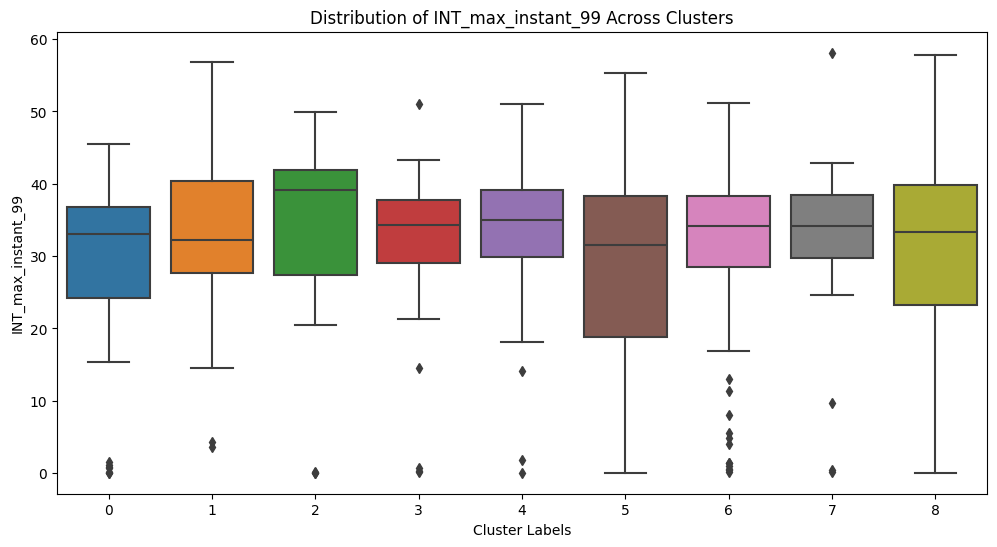

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

DCS_var = 'INT_max_instant_99'
# Convert the Dataset to a DataFrame
df = ds_all[[DCS_var, 'cluster_labels']].to_dataframe().reset_index()

# Filter out unclustered data if necessary (e.g., cluster label -1)
df_filtered = df[df['cluster_labels'] != -1]

plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_labels', y=DCS_var, data=df_filtered)
plt.title(f'Distribution of {DCS_var} Across Clusters')
plt.xlabel('Cluster Labels')
plt.ylabel(DCS_var)
plt.show()